# GroupE : Segmentation using DeepLabV3+ -- Inference

## Pretrained models (its frozen inference graph)

In [1]:
# runnable at colab 
# clone repo
!git clone https://github.com/SherifSabri/ImageSegmentationWithDeeplab.git

fatal: destination path 'ImageSegmentationWithDeeplab' already exists and is not an empty directory.


In [2]:
# change working directory
%cd /content/ImageSegmentationWithDeeplab/

/content/ImageSegmentationWithDeeplab


In [3]:
import glob

pascal_train_aug = "./models/research/deeplab/originalPretrainedModels/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb"
pascal_train_aug_8bit = "./models/research/deeplab/originalPretrainedModels/deeplabv3_mnv2_pascal_train_aug_8bit/frozen_inference_graph.tflite"

pascal_train_post_quantized_8bit = "./models/research/deeplab/postQuantizedModels/frozen_inference_graph_postquant.tflite"

pascal_train_post_quantized_8bit_success = "./models/research/deeplab/postQuantizedModels/frozen_inference_graph_success.tflite"
pascal_train_post_quantized_success = "./models/research/deeplab/postQuantizedModels/frozen_inference_graph_success.pb"
pascal_train_post_quantized_delayed = "./models/research/deeplab/postQuantizedModels/frozen_inference_graph_delayed_optimized.tflite"

PRETRAIN_PASCAL = [f for f in glob.glob(pascal_train_aug)]
PRETRAIN_PASCAL_POST = [f for f in glob.glob(pascal_train_post_quantized_success)]
for pbfile in PRETRAIN_PASCAL + PRETRAIN_PASCAL_POST:
    print(pbfile.split('/')[-2]+"/"+pbfile.split('/')[-1])

deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
postQuantizedModels/frozen_inference_graph_success.pb


## Import packages/modules

In [4]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import warnings
warnings.filterwarnings('ignore')

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

## DeepLabModel Class for Inference

In [0]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, pbfile):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    if True:
        graph_def = tf.GraphDef()
        with open(pbfile, "rb") as f:
            graph_def.ParseFromString(f.read())
    else:
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
          if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
            file_handle = tar_file.extractfile(tar_info)
            graph_def = tf.GraphDef.FromString(file_handle.read())
            break

        tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  
  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    #print(seg_map.shape)
    #print(seg_map)
    return resized_image, seg_map

######## EO-class

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')
  #print(colormap[label])
  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()



## Inference on one image using pre-trained model trained w/ Pascal VOC dataset

In [6]:
# Add An image as an HTTPS for testing
!wget -O test.jpg   https://images.pexels.com/photos/242829/pexels-photo-242829.jpeg
filename = 'test.jpg'

--2019-12-06 06:04:00--  https://images.pexels.com/photos/242829/pexels-photo-242829.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.209.102, 104.17.208.102, 2606:4700::6811:d166, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.209.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2875097 (2.7M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2019-12-06 06:04:00 (97.8 MB/s) - ‘test.jpg’ saved [2875097/2875097]



In [0]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', #0-4 
    'bottle', 'bus', 'car', 'cat', 'chair', #5-9
    'cow', 'diningtable', 'dog', 'horse', 'motorbike', #10-14
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv' #15-20
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

VOC Pascal Dataset based pre-trained models
model loaded successfully (postQuantizedModels)!
(513, 513)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


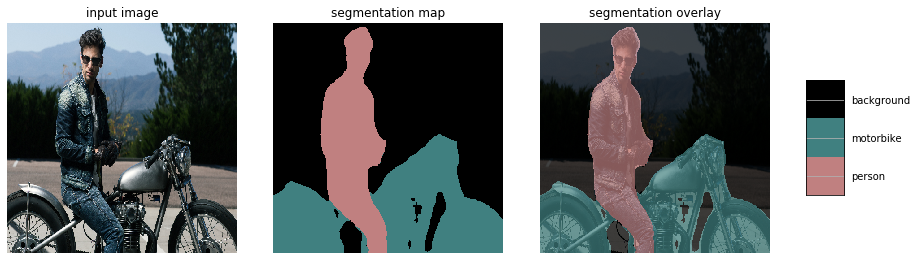

CPU times: user 2.59 s, sys: 88.2 ms, total: 2.68 s
Wall time: 2.01 s


In [11]:
%%time
print("VOC Pascal Dataset based pre-trained models")
for pbfile in PRETRAIN_PASCAL_POST:
    arch = pbfile.split('/')[-2]
    MODEL = DeepLabModel(pbfile)
    print("model loaded successfully (%s)!" % arch)
    # resize image 513x513 for float32 model 
    image = Image.open("test.jpg").resize((513, 513))
    resized_image, seg_map = MODEL.run(image)
    print(seg_map.shape)
    print(seg_map)
    vis_segmentation(resized_image, seg_map)

In [0]:
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def vis_segmentationQ(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

## Inference on the Quantized Model

In [13]:
interpreter=tf.lite.Interpreter(model_path=pascal_train_aug_8bit)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

print(interpreter.get_input_details())

image = Image.open("test.jpg").resize((h,w))
input_data=np.expand_dims(image, axis=0)
print(input_data.dtype)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

[{'name': 'MobilenetV2/MobilenetV2/input', 'index': 6, 'shape': array([  1, 513, 513,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128)}]
uint8


513 513
(1, 513, 513, 3)
(513, 513)
VOC Pascal Dataset based pre-trained models with 8-bit Quantization
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


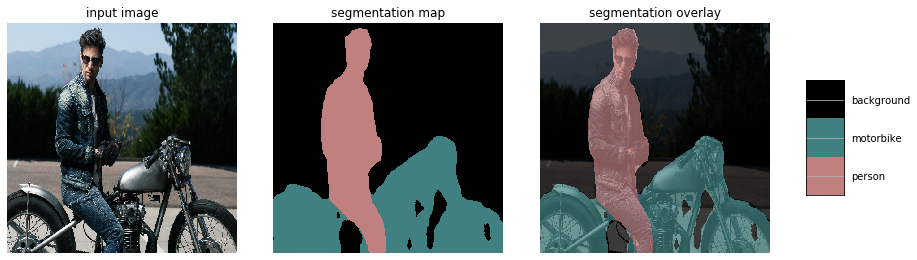

CPU times: user 418 ms, sys: 10.9 ms, total: 429 ms
Wall time: 427 ms


In [14]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("VOC Pascal Dataset based pre-trained models with 8-bit Quantization")
print(results)
vis_segmentationQ(image, results)

## Successful Inference on the Post Quantized Model

In [15]:
interpreter=tf.lite.Interpreter(model_path=pascal_train_post_quantized_8bit_success)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

print(input_details)

image = Image.open("test.jpg").resize((h,w))
input_data=np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

[{'name': 'MobilenetV2/MobilenetV2/input', 'index': 6, 'shape': array([  1, 513, 513,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128)}]


513 513
(1, 513, 513, 3)
(513, 513)
VOC Pascal Dataset based pre-trained models with 8-bit Quantization
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


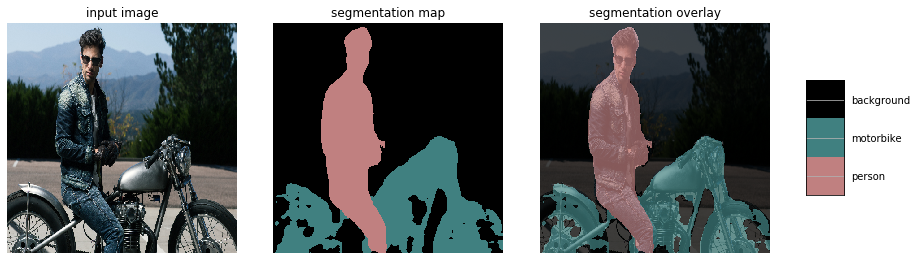

CPU times: user 400 ms, sys: 6.12 ms, total: 406 ms
Wall time: 413 ms


In [16]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("VOC Pascal Dataset based pre-trained models with 8-bit Quantization")
print(results)
vis_segmentationQ(image, results)

## Failed Inference on Quantized Aware trained model with delay

In [0]:
interpreter=tf.lite.Interpreter(model_path=pascal_train_post_quantized_delayed)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

print(input_details)

image = Image.open("test.jpg").resize((h,w))
input_data=np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

In [0]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("VOC Pascal Dataset based pre-trained models with 8-bit Quantization")
print(results)
vis_segmentationQ(image, results)

## Post Quantized Models

In [0]:
# Ref Inference for Quantized Model Evaluation 
Refmodel = "./models/research/deeplab/postQuantizationFineTuning/GTmodel/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb"

# Post Quantized Model
pascal_post_quantized_8bit_nofinetune = "./models/research/deeplab/postQuantizationFineTuning/FT-NO/postQuant_FTNO_FLOAT.tflite"
pascal_post_quantized_16bit_nofinetune = "./models/research/deeplab/postQuantizationFineTuning/FT-NO/postQuant_FTNO_float16_minmax.tflite"

pascal_post_quantized_8bit_10Kfinetune = "./models/research/deeplab/postQuantizationFineTuning/FT-10000/postQuant_FT10000_FLOAT.tflite"
pascal_post_quantized_16bit_10Kfinetune = "./models/research/deeplab/postQuantizationFineTuning/FT-10000/postQuant_FT10000_float16_minmax.tflite"



## Reference 32-float Model Inference 

(513, 513)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


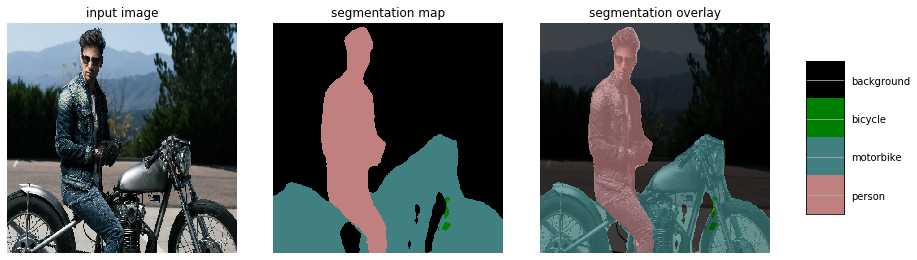

In [48]:
MODEL = DeepLabModel(Refmodel)
# resize image 513x513 for float32 model 
image = Image.open("test.jpg").resize((513,513))
resized_image, seg_map = MODEL.run(image)
print(seg_map.shape)
print(seg_map)
vis_segmentation(resized_image, seg_map)
Ref_Matrix = seg_map

## Post Quantized 8-bit model NO fine-tuning model 

---



In [49]:
interpreter=tf.lite.Interpreter(model_path=pascal_post_quantized_8bit_nofinetune)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

print(input_details)

image = Image.open("test.jpg").resize((h,w))
image = np.array(image)/255.
input_data=np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

[{'name': 'MobilenetV2/MobilenetV2/input', 'index': 6, 'shape': array([  1, 513, 513,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


513 513
(1, 513, 513, 3)
(513, 513)
Post 8-bit Quantization NO Fine-Tuning
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


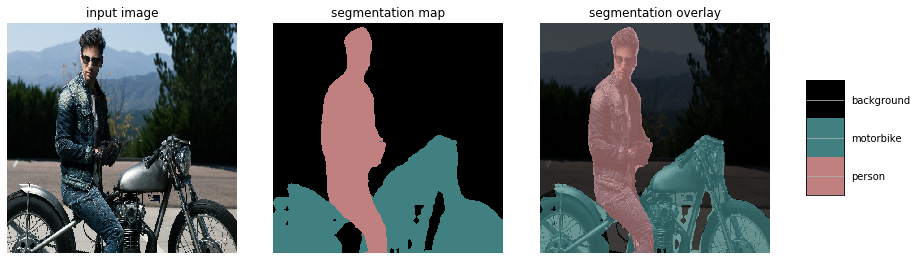

CPU times: user 447 ms, sys: 10.1 ms, total: 457 ms
Wall time: 459 ms


In [54]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("Post 8-bit Quantization NO Fine-Tuning")
print(results)
vis_segmentationQ(image, results)
noFineTune_8bit_Matrix = results

## Evaluation on the 8-bit Quantized Model (no-FT) w/r/t 32-bit Model

In [53]:
import numpy as np
synchro_toFLOAT = np.sum(np.equal(GT_Matrix, noFineTune_8bit_Matrix))/float(GT_Matrix.size)
print(synchro_toFLOAT)

0.5831727901082574


## Post Quantized 16-bit model NO fine-tuning model

In [55]:
interpreter=tf.lite.Interpreter(model_path=pascal_post_quantized_16bit_nofinetune)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

print(input_details)

image = Image.open("test.jpg").resize((h,w))
image = np.array(image)/255.
input_data=np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

[{'name': 'MobilenetV2/MobilenetV2/input', 'index': 6, 'shape': array([  1, 513, 513,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


513 513
(1, 513, 513, 3)
(513, 513)
Post 16-bit Quantization NO Fine-Tuning
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


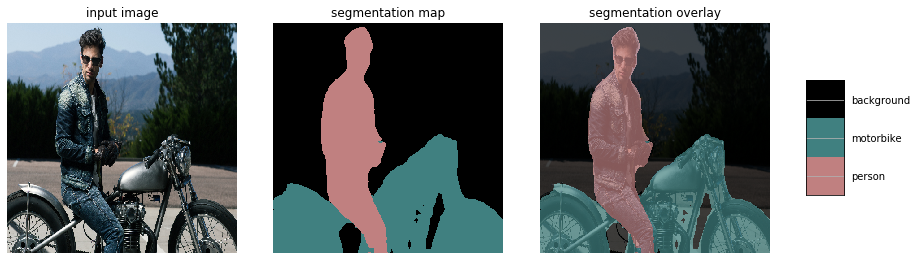

CPU times: user 428 ms, sys: 9.98 ms, total: 438 ms
Wall time: 441 ms


In [56]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("Post 16-bit Quantization NO Fine-Tuning")
print(results)
vis_segmentationQ(image, results)
noFineTune_16bit_Matrix = results

## Evaluation on the 16-bit Quantized Model (no-FT) w/r/t 32-bit Model

In [57]:
import numpy as np
synchro_toFLOAT = np.sum(np.equal(GT_Matrix, noFineTune_16bit_Matrix))/float(GT_Matrix.size)
print(synchro_toFLOAT)

0.574524355072216


## Comparison between 16-bit Quantized Model vs 8-bit Quantized Model

In [60]:
synchro_Quants = np.sum(np.equal(noFineTune_16bit_Matrix, noFineTune_8bit_Matrix))/float(noFineTune_16bit_Matrix.size)
print(synchro_Quants)

0.9890906603741322
